In [25]:
import numpy as np
import bls_cpu as gbls
import transitPy5 as tpy5
import os
# os.environ["OMP_NUM_THREADS"] = "15"

In [26]:
gbls_inputs = gbls.gbls_inputs_class() # Initialize needed inputs

tic = 29991541
gbls_inputs.lcdir    = "/data2/TESS/ffisearch/cvzsearch_yr1/cvz1pt003/tlc"+str(tic)+"/"
gbls_inputs.filename = "tlc"+str(tic)+"_5.dn.dat"

# Read in photometry to photclass
phot = tpy5.readphot(gbls_inputs.lcdir + gbls_inputs.filename)

# Remove any offset from time stamps
gbls_inputs.zerotime = 1325.0

# 0 == no plots ; 1 = make a plot ; 2 make a plot and save it ; 3 just save the plot
gbls_inputs.plots = 1  #default is 1 

# Set frequency range by setting freqs1 and freqs2
# gbls_inputs.freq1 = 1/100 # scan from 100 days to 2 days
# gbls_inputs.freq2 = 1/2

# Set stellar parameters for optimum duration search
# gbls_inputs.Mstar = 1.0  #default is M = 1, R = 1
# gbls_inputs.Rstar = 1.0

# Set multipro = 0 for single thread jobs.  Default is 1.  
# gbls_inputs.multipro = 1

In [27]:
## Data processing 

# # Simple sigma cut on the data
# fstd = np.std(phot.flux)
# fstd_flag  = (np.abs(phot.flux - np.median(phot.flux)) < tpy5_inputs.fstd_cut*fstd) # & badcut
# phot.time  = phot.time[fstd_flag]
# phot.flux  = phot.flux[fstd_flag]
# phot.ferr  = phot.ferr[fstd_flag]
# phot.itime = phot.itime[fstd_flag]
# phot.tflag = phot.tflag[fstd_flag]
# phot.icut  = phot.icut[fstd_flag]

# # Detrender
# tpy5.run_polyfilter(phot, tpy5_inputs) -- will add flux_f to phot class

# # Outlier rejection
# tpy5.run_cutoutliers(phot, tpy5_inputs)

In [28]:
# If you used data processing, use phot.flux_f
# importlib.reload(gbls)
# gbls_ans = gbls.bls(gbls_inputs, phot.time[phot.icut == 0], phot.flux[phot.icut == 0])

## Transit Modelling Section 

Note: in the utils folder run the following

`f2py -c tfit5.pyf transitmodel.f keplerian.f ttcor.f occultquad.f mandelagol.f rqsort.f transitdur.f -lgomp --f90flags='-fopenmp' --f77flags='-fopenmp'`  
  
`f2py -c fittransitmodel3.pyf precision.f90 fittermod.f90 fittransitmodel3.f90 getrhosig.f minpack.f transitmodel.f occultquad.f keplerian.f mandelagol.f ttcor.f -lgomp --f90flags='-fopenmp' --f77flags='-fopenmp'`  

and then copy (or move) the created `.so` files to the main code folder.

In [29]:
import transitfit5 as tf5 # will only load if the .so files are present (tfit5 and fittransitmodel.so
import utils_python.transitmodel as transitm
import utils_python.transitfit as transitf
import matplotlib.pyplot as plt
import importlib
import time

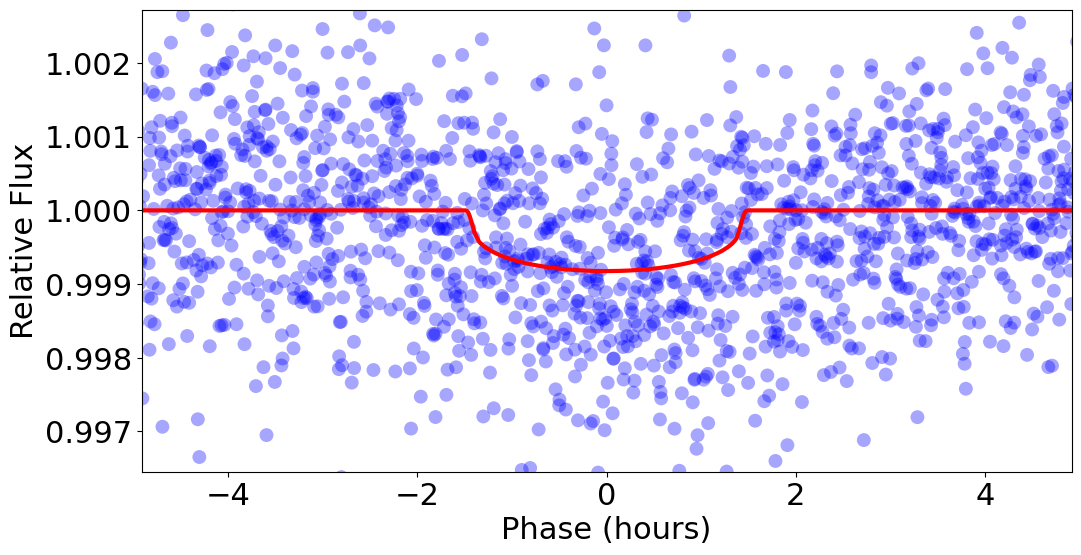

In [30]:
# A basic transit model

bper = 2.483415
epo = 0.44982
rp_rs = 0.0263

sol = np.zeros(18) # single planet model has up-to 18-model parameters

sol[0]  = 0.6  # Mean stellar density (g/cm^3)
sol[1]  = 0.0  # Only used for non-linear limb-darkening
sol[2]  = 0.0  # Only used for non-linear limb-darkening
sol[3]  = 0.6  # q1 (limb-darkening)
sol[4]  = 0.4  # q2 (limb-darkening)
sol[5]  = 0.0  # dilution
sol[6]  = 0.0  # Velocity offset
sol[7]  = 0.0  # photometric zero point
sol[8]  = epo            # Center of transit time (days)
sol[9]  = bper           # Orbital Period (days)
sol[10] = 0.5                    # Impact parameter
sol[11] = rp_rs # Rp/R*
sol[12] = 0.0  # sqrt(e)cos(w)
sol[13] = 0.0  # sqrt(e)sin(w)
sol[14] = 0.0  # RV amplitude (m/s)
sol[15] = 0.0  # thermal eclipse depth (ppm)
sol[16] = 0.0  # Ellipsodial variations (ppm)
sol[17] = 0.0  # Albedo amplitude (ppm)
tf5.transitplot(phot.time - gbls_inputs.zerotime, phot.flux + 1, sol, itime = phot.itime)

12.253345727920532
[0.01209903 0.         0.         0.6        0.4        0.
 0.         0.         0.46442017 2.483415   0.98553163 0.04955759
 0.         0.         0.         0.         0.         0.        ]


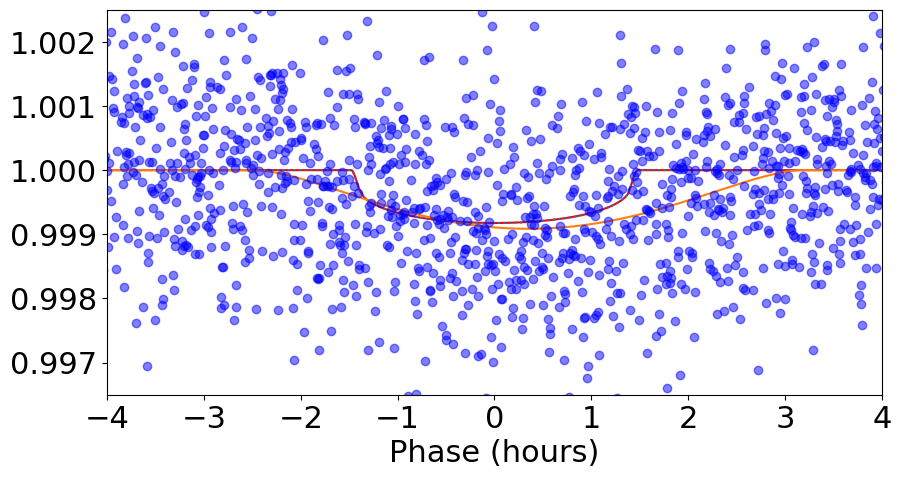

In [31]:
importlib.reload(transitm)
importlib.reload(transitf)

time_a = phot.time - gbls_inputs.zerotime
A = transitm.transitModel(sol, time_a, phot.itime, nintg=1)
tmodel = tf5.transitmodel(sol, time_a, itime = phot.itime)

s = time.time()
sol_fit = transitf.fitTransitModel(sol, time_a, phot.flux + 1, 1, phot.itime)
print(time.time() - s)
print(sol_fit)

phase = (time_a/bper - np.floor(time_a/bper) - epo/bper)*bper*24
i_sort = np.argsort(phase)
x = phase[i_sort]

plt.figure(figsize=(10,5))
plt.plot(x, A[i_sort], c="red")
plt.plot(x, tmodel[i_sort], linestyle="dotted")
plt.plot(x, transitm.transitModel(sol_fit, time_a, phot.itime)[i_sort])
plt.plot(phase, phot.flux + 1, "o", alpha=0.5, c="blue")
plt.xlabel("Phase (hours)")
plt.xlim(-4, 4)
plt.ylim(0.9965, 1.0025)
plt.show()

In [32]:
# Python vs fortran
importlib.reload(transitm)

# import numba
# numba.set_num_threads(48)

transitm.transitModel(sol, phot.time, phot.itime)

print("Python time:")
%timeit transitm.transitModel(sol, phot.time, phot.itime)
print("Fortran time:")
%timeit tf5.transitmodel(sol, phot.time, itime = phot.itime)

Python time:
6.73 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Fortran time:
9.05 ms ± 2.9 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
# Python vs fortran. More points
importlib.reload(transitm)

n = int(1e6)

t_min = min(phot.time)
t_max = max(phot.time)
time_a = np.linspace(t_min, t_max, n)
itime = np.full(n, phot.itime[0])

transitm.transitModel(sol, time_a, itime)

print("Python time:")
%timeit transitm.transitModel(sol, time_a, itime)
print("Fortran time:")
%timeit tf5.transitmodel(sol, time_a, itime = itime)

Python time:
446 ms ± 50.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Fortran time:
466 ms ± 40.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
# Single process vs Multi process
importlib.reload(transitm)

print("Single process:")
%timeit transitm.transitModel(sol, phot.time, phot.itime, multipro=False)
print("Multiprocessing:")
%timeit transitm.transitModel(sol, phot.time, phot.itime, multipro=True)

Single process:
338 ms ± 94.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Multiprocessing:
4.53 s ± 148 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [181]:
# Transit calculation vs no transit calculation
importlib.reload(transitm)

print("Transit calculation:")
%timeit -n 10 transitm.transitModel(sol, phot.time, phot.itime, multipro=False, calculate_transit=True)
print("No Transit calculation:")
%timeit -n 10 transitm.transitModel(sol, phot.time, phot.itime, multipro=False, calculate_transit=False)

Transit calculation:
144 ms ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
No Transit calculation:
125 ms ± 2.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [185]:
# Trying with more points
importlib.reload(transitm)

n = int(1e6)

t_min = min(phot.time)
t_max = max(phot.time)
time_a = np.linspace(t_min, t_max, n)
itime = np.full(n, phot.itime[0])

print("Single process:")
%timeit transitm.transitModel(sol, time_a, itime, multipro=False)
print("Multiprocessing:")
%timeit transitm.transitModel(sol, time_a, itime, multipro=True)

Single process:
1.34 s ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Multiprocessing:
3 s ± 88.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
